<a href="https://colab.research.google.com/github/JihoonPark99/Computer_Vision_Study/blob/main/CV_seminar_week7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [23]:
%cd /content/drive/MyDrive/CV_seminar_project

/content/drive/MyDrive/CV_seminar_project


In [24]:
%pwd

'/content/drive/MyDrive/CV_seminar_project'

GPU로 바꾸기

In [25]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# 1. 학습한 가중치 불러오기 

In [4]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device 배정
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)
device

'cuda'

In [5]:
import torch
# state_dict = torch.load('resnet50.pth')
state_dict = torch.load('/content/drive/MyDrive/CV_seminar_project/resnet50.pth')

In [6]:
state_dict.keys()

dict_keys(['net', 'epoch', 'test_loss', 'train_loss', 'train_acc', 'test_acc'])

In [13]:
# best_epoch = state_dict['epoch']
best_test_acc = state_dict['test_acc']
best_epoch = state_dict['epoch']
weights = state_dict['net']

print(f'최종적으로 { best_epoch }번째 에포크에서 test셋 기준으로 {best_test_acc}를 달성하였습니다.')
#나중엔 10에 변수를 넣자




최종적으로 93번째 에포크에서 test셋 기준으로 92.504를 달성하였습니다.


# 2. 학습한 가중치를 모델에 적용하기

In [14]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu' # device 배정
torch.manual_seed(42)
if device == 'cuda':
  torch.cuda.manual_seed_all(42)
device

'cuda'

In [17]:
# 모델불러오기
from torchvision import models # 모델 라이브러리 함수

resnet_50 = models.resnet50(pretrained=False).to(device) # 선행학습 여부

# finetuning
import torch.nn as nn # 파이토치 뉴럴네트워크 layer 라이브러리
resnet_50.fc = nn.Linear(resnet_50.fc.in_features, 3).to(device)

## 학습한 가중치를 적용하기
resnet_50.load_state_dict(weights) 

<All keys matched successfully>

# 데이터셋 불러오기

In [32]:
from dataset import Custom_dataset as C
from torch.utils.data import Dataset, DataLoader
import cv2
import os 
import torch
import torch.nn as nn
import torchvision
from torchvision import transforms # 이미지 데이터 augmentation
import glob
import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2 # albumentations 텐서화 함수

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [29]:
# 하이퍼 파라미터
batch_size = 8
lr = 0.0001
epochs = best_epoch 
optimizer_name = 'adam'
model_name = 'resnet50'
criterion = nn.CrossEntropyLoss().to(device) # cost function

In [30]:


root_path = '/content/drive/MyDrive/CV_seminar_project'

train_transforms = A.Compose([
    A.Resize(224,224),
    A.Transpose(p=0.5),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5),
    A.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=20, val_shift_limit=20, p=0.5),
    A.RandomBrightnessContrast(brightness_limit=(-0.1,0.1), contrast_limit=(-0.1, 0.1), p=0.5),
    A.ChannelShuffle(),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 이미지넷 데이터셋 통계값으로 Normalize
    A.CoarseDropout(p=0.5),
    ToTensorV2()
])

test_transforms = A.Compose([
    A.Resize(224,224),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), max_pixel_value=255.0, always_apply=False, p=1.0), # 텐서타입은 안해줌
    ToTensorV2() # Normalize를 먼저하고 tensor화를 진행해야한다.
])

### Pytorch 데이터 클래스 생성
train_class = C(root_path=root_path, mode='train', transforms=train_transforms)
valid_class = C(root_path=root_path, mode='valid', transforms=test_transforms)
test_class = C(root_path=root_path, mode='test', transforms=test_transforms)

### Pytorch BatchLoader 생성 (학습에 이용할 최종 dataloader)
from torch.utils.data import DataLoader as DataLoader

train_loader = DataLoader(train_class, batch_size=batch_size, shuffle = True, num_workers=0)
valid_loader = DataLoader(valid_class, batch_size=batch_size, shuffle = False, num_workers=0)
test_loader = DataLoader(test_class, batch_size=batch_size, shuffle = False, num_workers=0)


# 3. 최종 성능 확인하기(96%)
과제
> 모델은 100epochs 돌려서 만든 가중치를 이용한다.     


In [31]:
optimizer = torch.optim.Adam(resnet_50.parameters(), lr = lr, weight_decay = 1e-8)

In [33]:
train_acc_lst = []
train_loss_lst = []

test_acc_lst = []
test_loss_lst = []
epochs = best_epoch
save_dir = '/content/drive/MyDrive/CV_seminar_project'
model_name = 'resnet50'

for epoch in range(1, epochs):
  running_loss = 0.0
  test_running_loss = 0.0

  total = 0
  correct = 0
  
  train_acc = 0
  test_acc = 0

  resnet_50.train()
  for i, (train_img, train_label) in enumerate(train_loader):
    # gpu에 할당
    train_img = train_img.to(device)
    train_label = train_label.to(device)
    optimizer.zero_grad( set_to_none = True ) # 계산했던 가중치 초기화

    output = resnet_50(train_img) # 모델에 입력
    loss = criterion(output, train_label)
    loss.backward() # 미분
    optimizer.step() # 학습

    # loss & acc
    running_loss += loss.item()
    _, predictions = torch.max(output.data ,dim = 1 )
    
    total += train_label.size(0)
    correct += (predictions == train_label).sum().item()
    train_acc += 100 * (correct/total)

  running_loss = round(running_loss/(i+1), 3) # 소수점 반올림
  train_acc = round(train_acc/(i+1), 3)
  
  print(f'Trainset{epoch}/{epochs} Loss : {running_loss}, Accuracy : {train_acc}%')
  train_acc_lst.append(train_acc)
  train_loss_lst.append(running_loss)


  total = 0
  correct = 0
  resnet_50.eval()
  with torch.no_grad(): 
    for ii, (test_img, test_label) in enumerate(test_loader):
          # gpu에 할당
      test_img = test_img.to(device)
      test_label = test_label.to(device)

      output = resnet_50(test_img) # 모델에 입력
      loss = criterion(output, test_label)

      # loss & acc
      test_running_loss += loss.item()
      _, predictions = torch.max(output.data ,dim = 1 )
      
      total += test_label.size(0)
      correct += (predictions == test_label).sum().item()
      test_acc += 100 * (correct/total)

  test_running_loss = round(test_running_loss/(ii+1), 3) # 소수점 반올림
  test_acc = round(test_acc/(ii+1), 3)
  print(f'Testset{epoch}/{epochs} Loss : {test_running_loss}, Accuracy : {test_acc}% \n')
  test_acc_lst.append(test_acc)
  test_loss_lst.append(test_running_loss)

  if np.max(test_acc_lst) <= test_acc : #현재 에포크의 test_acc가 가장 좋은 성능이라면
    weights = resnet_50.state_dict()    #지금 모델의 가중치를 저장한다. 
    check_point = {
        'net' : weights,
        'epoch' : epoch,

        'test_loss' : test_running_loss,
        'train_loss' : running_loss,

        'train_acc' : train_acc,
        'test_acc' : test_acc
    }
    torch.save(check_point, save_dir + f'/{model_name}test.pth')


Trainset1/93 Loss : 0.094, Accuracy : 95.408%
Testset1/93 Loss : 0.276, Accuracy : 94.42% 

Trainset2/93 Loss : 0.132, Accuracy : 96.55%
Testset2/93 Loss : 0.39, Accuracy : 92.063% 

Trainset3/93 Loss : 0.086, Accuracy : 97.433%
Testset3/93 Loss : 0.429, Accuracy : 91.891% 

Trainset4/93 Loss : 0.091, Accuracy : 96.434%
Testset4/93 Loss : 0.348, Accuracy : 93.04% 

Trainset5/93 Loss : 0.17, Accuracy : 96.314%
Testset5/93 Loss : 0.51, Accuracy : 88.133% 

Trainset6/93 Loss : 0.11, Accuracy : 95.517%
Testset6/93 Loss : 0.373, Accuracy : 88.692% 

Trainset7/93 Loss : 0.083, Accuracy : 97.648%
Testset7/93 Loss : 0.339, Accuracy : 91.303% 

Trainset8/93 Loss : 0.155, Accuracy : 94.665%
Testset8/93 Loss : 0.274, Accuracy : 94.111% 

Trainset9/93 Loss : 0.066, Accuracy : 97.89%
Testset9/93 Loss : 0.279, Accuracy : 92.506% 

Trainset10/93 Loss : 0.065, Accuracy : 97.836%
Testset10/93 Loss : 0.351, Accuracy : 91.846% 

Trainset11/93 Loss : 0.083, Accuracy : 96.731%
Testset11/93 Loss : 0.253, Ac

In [36]:
print('Best epoch, test_loss, test_acc : ',check_point['epoch'] , check_point['test_loss'] , check_point['test_acc'])

Best epoch, test_loss, test_acc :  32 0.343 96.189


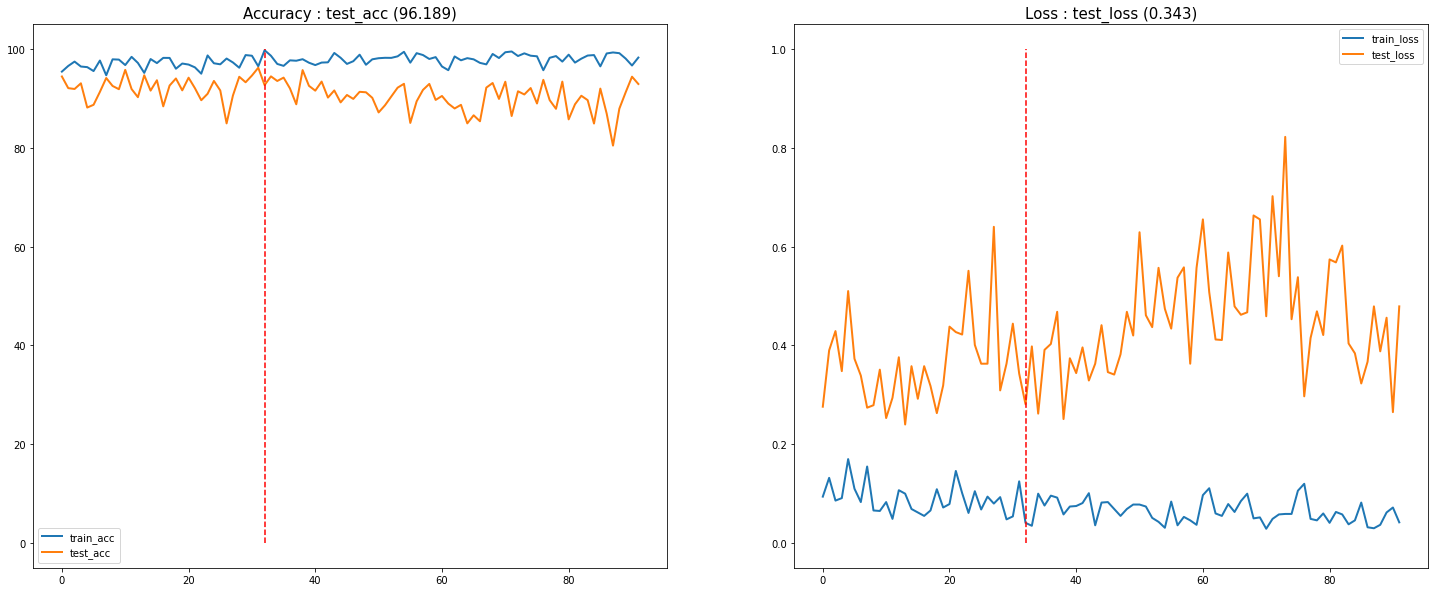

In [35]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
import numpy as np

fig, axes = plt.subplots(nrows=1, ncols = 2, figsize = (25, 10))

axes[0].plot(np.arange(len(train_acc_lst)), train_acc_lst, label = 'train_acc', linewidth=2)
axes[0].plot(np.arange(len(test_acc_lst)), test_acc_lst, label = 'test_acc', linewidth=2)
axes[0].plot([check_point['epoch'],check_point['epoch']], [0,100], color='red', linestyle='--')
axes[0].set_title('Accuracy : test_acc ({})'.format(check_point['test_acc']), fontsize=15)
axes[0].legend(loc='best')

axes[1].plot(np.arange(len(train_loss_lst)), train_loss_lst, label = 'train_loss', linewidth=2)
axes[1].plot(np.arange(len(test_loss_lst)), test_loss_lst, label = 'test_loss', linewidth=2)
axes[1].plot([check_point['epoch'],check_point['epoch']], [0,1], color='red', linestyle='--')
axes[1].set_title('Loss : test_loss ({})'.format(check_point['test_loss']), fontsize=15)
axes[1].legend(loc='best')